# Outlier Detection 

In this exercise, we are providing you with an example of financial data (all numbers are fictional).

You need to create an algorithm that can find outliers in this data by one column / several columns. E.g. some members have extremely high costs in the current month and your solution should be able to detect such records. Think about features and how you would explain them to business people.

In [16]:
import pandas as pd


In [17]:
data = pd.read_csv("/Users/rosiebai/Downloads/datasets-8/sfr_test.csv")

In [18]:
data.head()

,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,...,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
0,1,F,21/06/1990,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,...,$0.00,"$3,507.00",$0.00,$7.92,$0.00,$0.00,$0.00,$0.00,$0.00,$843.78
1,2,M,02/01/1948,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,$0.00,"$6,204.84",$0.00,$8.13,$0.00,"$11,289.69",$0.00,"$10,688.46","$10,859.82",$906.77
2,3,M,14/06/1948,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,...,$0.00,"$4,012.46",$0.00,$7.92,$0.00,$0.00,$0.00,$0.00,$0.00,$815.84
3,4,M,10/02/1954,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,1,HMO,...,$0.00,"$9,770.61",$0.00,$8.30,$0.00,$73.88,$0.00,$62.87,$64.91,$846.26
4,5,M,31/12/1953,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,$0.00,"$19,976.13","$8,875.80",$8.90,$0.00,$522.48,$0.00,$517.56,$606.01,$867.55


In [19]:
data.columns

Index(['member_unique_id', 'gender', 'dob', 'eligible_year', 'eligible_month',
       'affiliation_type', 'pbp_group', 'plan_name', 'npi', 'line_of_business',
       'esrd', 'hospice', 'ipa_funding', 'ma_premium', 'ma_risk_score',
       'mbr_with_rx_rebates', 'partd_premium', 'pcp_cap', 'pcp_ffs',
       'plan_premium', 'prof', 'reinsurance', 'risk_score_partd', 'rx',
       'rx_rebates', 'rx_with_rebates', 'rx_without_rebates', 'spec_cap'],
      dtype='object')

In [20]:
data.shape

(10530, 28)

## 1. Select key cost features

In [21]:
# Choose cost_related columns that directly refelct member-level financial utilization: 
cost_columns = [
    'plan_premium',
    'pcp_cap',
    'prof',
    'reinsurance',
    'rx_with_rebates',
    'spec_cap'
]

## 2. Convert financial columns to numeric 

In [22]:
for col in cost_columns:
    data[col] = data[col].replace('[\$,]', '', regex = True).astype(float)

## 3. Feature engineering

- total_cost = sum of all cost components
- rx_ratio = rx_with_rebates / total_cost --> is drug spending driving cost?
- prof_ratio = prof / total_cost  --> is specialist cost high?

In [23]:
data['total_cost'] = data[cost_columns].sum(axis = 1)
data['rx_ratio'] = data['rx_with_rebates']/data['total_cost']
data['prof_ratio'] = data['prof']/data['total_cost']

## 4. Detecting Outliers

In [24]:
# 1. simple statistical rule 
mean_cost = data['total_cost'].mean()
std_cost = data['total_cost'].std()
data['is_outlier_z'] = data['total_cost'] > (mean_cost + 3 * std_cost) 

In [25]:
# 2. IQR method 
q1 = data['total_cost'].quantile(0.25)
q3 = data['total_cost'].quantile(0.75)
IQR = q3 - q1
data['is_outlier_iqr'] = data['total_cost'] > (q3 + 1.5 * IQR)

In [26]:
# 3. Multivariate Outlier Dectection (for multiple features)
from sklearn.ensemble import IsolationForest

features = data[['plan_premium', 'prof','rx_with_rebates','spec_cap','total_cost']]
model = IsolationForest(contamination = 0.01, random_state = 42)
data['is_outlier_iso'] = model.fit_predict(features) == -1


/Users/rosiebai/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


### why these features?
1. plan _premium: represents what the member is expected to pay monthly (fixed cost).
2. prof (professional service cost): represents specialist/physician fee-for-service. Often a large driver of varaible cost.
3. rx_with_rebates: represents net prescription drug cost (after manuafcturer rebates). Drug costs can be a huge source of outliers. Using the net cost avoids overstimating due to rebates. 
4. spec_cap (specialist capitation): represents a fixed per-member payment to specialists regardless of utilization. Captures cost exposure for patients in capitated plans. Can help distinguish outliers driven by risk-based contracts versus FFS.
5. total_cost: represents the sum of all relevant cost columns.

## 5. Correlation analysis

### Step 1: Compare outliers vs non-outliers

After we detected the outliers, we still need to find out what features are correlated to the outliers. If we chose the isolation forest method, let's compare the outliers vs non-outliers.

In [27]:
data.head()

,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,...,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap,total_cost,rx_ratio,prof_ratio,is_outlier_z,is_outlier_iqr,is_outlier_iso
0,1,F,21/06/1990,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,...,$0.00,0.00,$0.00,843.78,4833.53,0.000000,0.00000,False,False,False
1,2,M,02/01/1948,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,$0.00,10688.46,"$10,859.82",906.77,18265.24,0.585180,0.00000,False,False,False
2,3,M,14/06/1948,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,...,$0.00,0.00,$0.00,815.84,5318.85,0.000000,0.00000,False,False,False
3,4,M,10/02/1954,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,1,HMO,...,$0.00,62.87,$64.91,846.26,11157.08,0.005635,0.00000,False,False,False
4,5,M,31/12/1953,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,$0.00,517.56,$606.01,867.55,30773.92,0.016818,0.28842,False,False,False


In [30]:
outliers = data[data['is_outlier_iso'] == True]
non_outliers = data[data['is_outlier_iso']!= True]

In [36]:
summary = data.groupby('is_outlier_iso')[features.columns].mean().T
summary['pct_diff'] = round(100 * (summary[True] - summary[False])/ summary[False],2)
summary

is_outlier_iso,False,True,pct_diff
plan_premium,12376.795096,36822.369623,197.51
prof,351.772107,5864.146604,1567.03
rx_with_rebates,1362.266444,82313.893208,5942.42
spec_cap,811.613717,844.051604,4.00
total_cost,15418.942091,126371.835189,719.59


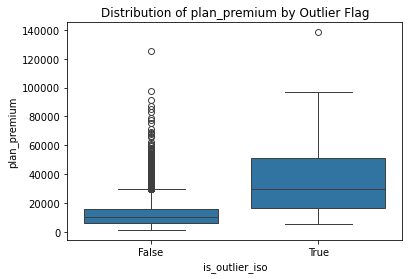

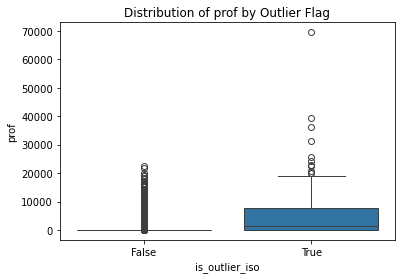

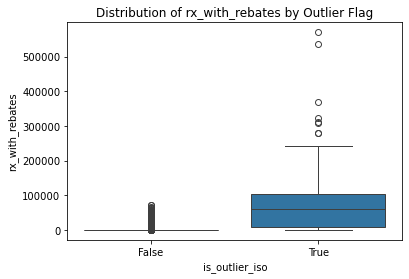

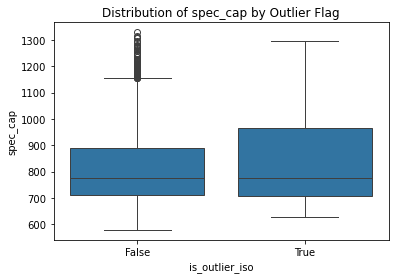

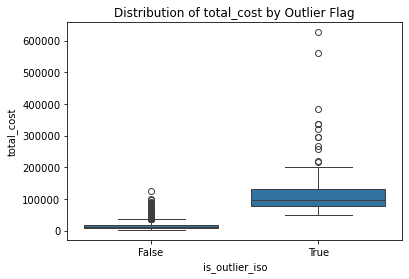

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt 
for col in features.columns:
    plt.figure(figsize = (6,4))
    sns.boxplot(data = data, x = 'is_outlier_iso', y = col)
    plt.title(f'Distribution of {col} by Outlier Flag')
    plt.show()

### Step 2: We can also compute the point-biserial correlation, since is_outlier_iso is binary:

In [38]:
from scipy.stats import pointbiserialr
for col in features.columns:
    r, p = pointbiserialr(data['is_outlier_iso'], data[col])
    print(f"{col}: correlation = {r:.3f}, p-value = {p:.4f}")

plan_premium: correlation = 0.266, p-value = 0.0000
prof: correlation = 0.308, p-value = 0.0000
rx_with_rebates: correlation = 0.583, p-value = 0.0000
spec_cap: correlation = 0.024, p-value = 0.0138
total_cost: correlation = 0.618, p-value = 0.0000


### Step 3: Use a model to identify feature importance

In [39]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(features, data['is_outlier_iso'])
importances = pd.Series(clf.feature_importances_, index = features.columns)
importances.sort_values(ascending = False)

total_cost         0.477342
rx_with_rebates    0.265777
prof               0.119169
plan_premium       0.081156
spec_cap           0.056557
dtype: float64

This tells us total_cost and rx_with_rebates are best at distinguishing outliers. 